In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
# Comment below if you want to display the warnings (quite verbose here in the modeling part)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# We put both target arrays (regression and classification) in the same txt file
# As both target arrays have the same size we just need to split it it two
# and get the correct part for the prediction task
target = np.split(np.loadtxt('target.txt'), 2)[1].flatten()
features = pd.read_csv('features.csv')

# User id as index
features = features.set_index('user_id')

In [3]:
features.head()

,tw_lag7_watched,tw_lag6_watched,tw_lag5_watched,tw_lag4_watched,tw_lag3_watched,tw_lag2_watched,tw_lag1_watched,average_completion,total_sessions,num_genre,...,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
user_id,,,,,,,,,,,,,,,,,,,,,
AADDJF,0.000000,115.841750,3.622533,0.000000,0.000000,0.000000,0.000000,0.534068,7,7,...,0,0,0,1,0,0,0,1,0,0
AADVCF,104.502533,68.422800,11.407633,44.933767,15.139300,0.146700,22.515167,0.207554,38,7,...,0,1,0,0,0,0,0,0,1,0
AADWBM,27.124283,59.183333,0.000000,0.000000,0.000000,0.000000,0.000000,0.453004,4,3,...,0,0,0,0,0,0,0,1,0,0
AAHITE,0.356717,167.613733,58.899383,10.311800,55.222833,59.831783,61.613833,0.567544,20,4,...,0,0,0,0,0,1,0,1,0,0
AAKIJG,28.299717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062762,15,2,...,0,0,0,0,0,0,0,0,0,1


In [4]:
target[:10]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.])

In [5]:
# Let's check our baseline score
sum(target)/len(target)

0.40553298935119114

In [6]:
# Let's also check the score of the most common class, which given is target class 0
sum(target==0)/len(target) #This is prediction of guessing just based on proportions - so we need our above score to beat 60%

0.59446701064880891

In [7]:
# Let's build a simple tree based classification model
from sklearn import tree

# Accuracy as our error evaluation
from sklearn.metrics import accuracy_score

# We will use cross validation, so import helper functions for this
from sklearn.model_selection import cross_val_score, cross_val_predict

In [9]:
#max_depth = most questions asked before making a classification.
#min_samples_leaf = min samples to become a leaf node.
# Setup the model and develop a simple grid search against some key parameters
DT_param_max_depth=[2,3,4,6,8,10]
DT_param_min_leaf=[75,90,100,110,125,150]

In [10]:
# Let's keep track of our best parameters
DT_best_score=0
DT_best_param=[0,0]

# We will use the itertools library to try all the possible combinations of paramaters
# We could also have used the gridsearchCV capability in scikit learn
for c in itertools.product(DT_param_max_depth,DT_param_min_leaf):
    treeclass=tree.DecisionTreeClassifier(max_depth=c[0],min_samples_leaf=c[1])
    scores=cross_val_score(treeclass,
                           features,
                           target,
                           scoring='accuracy')
    if np.mean(scores)>DT_best_score:
        DT_best_score=np.mean(scores)
        DT_best_param=c

# Print the overall best results for depth and min leaf.
print('Best Settings: Max Depth:',DT_best_param[0],'- Min Sample Leaf:',DT_best_param[1])
print('Score:',DT_best_score)
#So this means that we would expect our best decision tree model to correctly classify just under 80% of our users as either 
#engaged or not engaged within our two-week test period, based upon our features from the previous 14 weeks.

Best Settings: Max Depth: 6 - Min Sample Leaf: 110
Score: 0.788341822543


In [11]:
# Let's keep our best model (hyperparameters tuned)
treeclass=tree.DecisionTreeClassifier(max_depth=DT_best_param[0],
                                      min_samples_leaf=DT_best_param[1])
DT=treeclass.fit(features,target)

In [12]:
# The model has been trained on the entire dataset - i.e. the output we are comparing our
# predictions with here have been used to estimate the parameters
DT.score(features,target)
#Aim to see a similar score - shows the model is not overfitting. This score is similar to the out of sample score - meaning 
#that nothing has the training set is not overfit to our model and will be good for general data.

0.80052695136678009

In [13]:
# Ranking features importance
feature_impDT=pd.DataFrame(
    {'feature': list(features.columns),
     'importance': list(DT.feature_importances_)
    })
feature_impDT.sort_values(by='importance', ascending=False).reset_index(drop=True).head(10)
#Here we can see the the most important feature for predicting iPlayer engagement in our target two-week group is the number of
#minutes viewed in the two previous weeks. The number of sessions within the past 14 weeks is also important, 
#but to a much lesser extent.

,feature,importance
0,tw_lag1_watched,0.704153
1,total_sessions,0.107251
2,tw_lag3_watched,0.088443
3,tw_lag2_watched,0.056234
4,tw_lag5_watched,0.022403
5,tw_lag7_watched,0.009806
6,num_genre,0.004526
7,num_timeday,0.001991
8,most_genre_Drama,0.001763
9,average_completion,0.001483


In [14]:
# Let's build a random forrest
from sklearn.ensemble import RandomForestClassifier

In [15]:
# Setup the model and develop a simple grid search against some key parameters. Find best parameters
RF_param_max_depth=[2,3,4,6,8,10]
RF_param_min_leaf=[75,90,100,110,125,150]

In [16]:
# Let's keep track of our best parameters
RF_best_score=0
RF_best_param=[0,0]

# We will use the itertools library to try all the possible combinations of paramaters
# We could also have used the gridsearchCV capability in scikit learn
for c in itertools.product(RF_param_max_depth,RF_param_min_leaf):
    forrestclass=RandomForestClassifier(n_estimators=200,
                                        max_depth=c[0],min_samples_leaf=c[1])
    scores=cross_val_score(forrestclass,
                           features,
                           target,
                           scoring='accuracy')
    if np.mean(scores)>RF_best_score:
        RF_best_score=np.mean(scores)
        RF_best_param=c

# Print the overall best results and hence the hyperparameters.
print('Best Settings: Max Depth:',RF_best_param[0],'- Min Sample Leaf:',RF_best_param[1])
print('Score:',RF_best_score)

Best Settings: Max Depth: 8 - Min Sample Leaf: 75
Score: 0.791964324061


In [17]:
# Let's keep our best model (hyperparameters tuned)
forrestclass=RandomForestClassifier(n_estimators=200,
                                    max_depth=RF_best_param[0],
                                    min_samples_leaf=RF_best_param[1])
RF=forrestclass.fit(features,target)

In [18]:
# In-sample accuracy
RF.score(features,target)
#A similar in- and out-of sample accuracy, just like for the decision tree, is a positive indication that the model is not 
#overfitting.

0.79975848062355914

In [19]:
# Features importance
feature_impRF=pd.DataFrame(
    {'feature': list(features.columns),
     'importance': list(RF.feature_importances_)
    })
feature_impRF.sort_values(by='importance', ascending=False).reset_index(drop=True).head(10)
#As shown here - importance is more spread out compared to the single decision tree.

,feature,importance
0,tw_lag1_watched,0.235491
1,tw_lag2_watched,0.185628
2,total_sessions,0.127934
3,tw_lag3_watched,0.104891
4,num_weekday,0.081201
5,num_genre,0.069030
6,tw_lag4_watched,0.061180
7,tw_lag5_watched,0.055172
8,num_timeday,0.034880
9,tw_lag7_watched,0.014915


In [20]:
# Let's build a logistic regression
from sklearn import linear_model

In [21]:
# setup the model and develop a simple grid search against some key parameters
#With large C values - the more overfit the data tends to be.
LR_param_C=[0.001,0.01,0.1,1.0,10,100,1000]

In [22]:
# Let's keep track of our best parameters
LR_best_score=0
LR_best_param=0

# we will setup a manual grid search, but you can also use the gridsearchCV capability in sklearn
for i in LR_param_C:
    logclass=linear_model.LogisticRegression(C=i)
    scores=cross_val_score(logclass,
                           features,
                           target,
                           scoring='accuracy')
    if np.mean(scores)>LR_best_score:
        LR_best_score=np.mean(scores)
        LR_best_param=i

# print the overall best results
print('Best Settings: C:',LR_best_param)
print('Score:',LR_best_score)

Best Settings: C: 0.01
Score: 0.776155854981


In [23]:
# Let's keep our best model (hyperparameters tuned)
logclass=linear_model.LogisticRegression(C=LR_best_param)
LR=logclass.fit(features,target)

In [24]:
# In-sample accuracy
LR.score(features,target) #Shows a similar score

0.77538697990997918

In [25]:
# First, let's have a look at the highest magnitude positive coefficients.
coefLR=pd.DataFrame(
    {'feature': list(features.columns),
     'coef': list(LR.coef_.flatten())
    })
coefLR.sort_values(by='coef',ascending=False).reset_index(drop=True).head()

,coef,feature
0,0.242909,num_weekday
1,0.111940,num_genre
2,0.010676,num_timeday
3,0.006800,tw_lag1_watched
4,0.003030,total_sessions


In [26]:
# Then, lets have a look at the highest magnitude negative coefficients.
coefLR.sort_values(by='coef',ascending=False).reset_index(drop=True).tail()

,coef,feature
29,-0.251298,most_timeday_Afternoon
30,-0.292194,most_genre_Factual
31,-0.295835,most_genre_Drama
32,-0.376400,most_timeday_Night
33,-0.395360,most_timeday_Evening


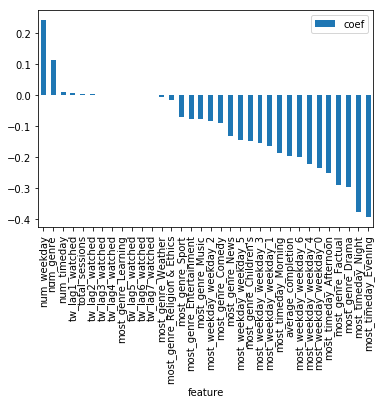

In [27]:
# Now let's plot them all
coefLR=coefLR.set_index(['feature'])
coefLR.sort_values(by='coef', ascending=False).plot(kind='bar')
plt.show()

In [28]:
# Let's try to get some non linear patterns
from sklearn import svm #Support vector machine

In [29]:
# setup the model and develop a simple grid search against some key parameters
SVM_param_C=[0.001,0.01,0.1,1.0,10,100,1000] #Same grid search as before

In [30]:
# Let's keep track of our best parameters
SVM_best_score=0
SVM_best_param=0

# we will setup a manual grid search, but you can also use the gridsearchCV capability in sklearn
for i in SVM_param_C:
    svcclass=svm.SVC(C=i, kernel='rbf')
    scores=cross_val_score(svcclass,
                           features,
                           target,
                           scoring='accuracy')
    if np.mean(scores)>SVM_best_score:
        SVM_best_score=np.mean(scores)
        SVM_best_param=i

# print the overall best results
print('Best Settings: C:',SVM_best_param)
print('Score:',SVM_best_score)

Best Settings: C: 1.0
Score: 0.700186428573


In [31]:
# Let's keep our best model (hyperparameters tuned)
svcclass=svm.SVC(C=SVM_best_param, kernel='rbf')
SVM=svcclass.fit(features,target)

In [32]:
# In-sample error
SVM.score(features,target)

0.9425842573279174

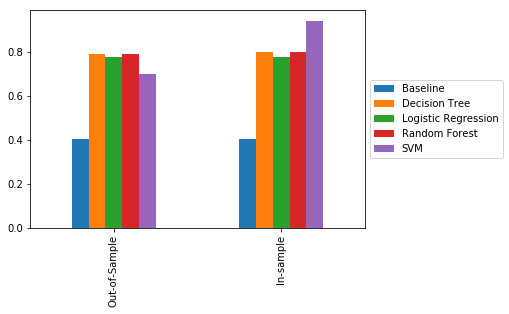

In [35]:
# Let's plot the out-of-sample and in-sample performance of our models
scores = pd.DataFrame({'Baseline':[sum(target)/len(target), sum(target)/len(target)],
                       'Decision Tree':[DT_best_score, DT.score(features,target)], 
                       'Random Forest':[RF_best_score, RF.score(features,target)],
                       'Logistic Regression':[LR_best_score, LR.score(features,target)], 
                       'SVM':[SVM_best_score, SVM.score(features,target)] },
                      index=['Out-of-Sample','In-sample'])

scores.plot(kind='bar') #Removed colormap due to the blue colour scheme left baseline white - same colour as the background
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [36]:
#Conclusions
#SVM was not modelled very well and is overfit to the data. This means it will perform poorly with generalised data.
#The other 3 models performed very well with random forest performing slightly lower.